# Power Spectrum Analysis

## Configuration

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pickle
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
from deep_dss.helpers import *
import pymaster as nmt
import warnings

warnings.filterwarnings(action='once')

# Run on GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Defaults
plt.rcParams.update({
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'text.color':'black',
'text.usetex': True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelcolor':'black',
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Config variables
config = "ck"
zscale = True
nside = 1024
order = 2
gaussian = False
free_bias = False
prior_low = 0.8
prior_high = 3.0

In [6]:
# Using covariance Q1 data
# data = split_count_and_lensing_maps_by_dataset("COVQ1", config=config, covariance=True, zscale=zscale)
data = split_count_and_lensing_maps_by_vals([201], config=config, covariance=True, zscale=zscale)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site

In [7]:
data

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'x': array([[[ 0.        , -1.01371929],
         [ 0.        , -0.299405  ],
         [ 0.        ,  0.27382059],
         ...,
         [ 0.        , -0.43330287],
         [ 0.        , -1.01612761],
         [ 0.        , -1.21846043]],
 
        [[ 0.        ,  0.93302327],
         [ 0.        , -0.38506608],
         [ 1.        ,  0.24338131],
         ...,
         [ 0.        ,  0.50579427],
         [ 0.        ,  0.5116162 ],
         [ 2.        ,  0.26097505]],
 
        [[ 0.        , -1.47426815],
         [ 0.        , -1.33638096],
         [ 0.        , -0.60784905],
         ...,
         [ 2.        , -1.07038273],
         [ 3.        ,  2.30057749],
         [ 1.        ,  1.32391871]],
 
        ...,
 
        [[ 0.        , -1.50377169],
         [ 1.        , -1.18341234],
         [ 0.        , -2.03975963],
         ...,
         [ 1.        ,  1.21231524],
         [ 0.        ,  1.93704527],
         [ 0.        , -0.19952708]],
 
        [[ 0.        , -

In [8]:
data = data["x"]
data.shape

(48, 262144, 2)

## Computing C_ells

In [9]:
bias = 1.54
density_arcmins = 0.04377 # Tracer density, galaxies/arcmin^2
density_steradians = density_arcmins * 3600 * (180/np.pi)**2

In [10]:
density_steradians

517278.36218405055

In [ ]:
# Create mask for partial sky maps
mask_map = np.zeros(hp.nside2npix(nside))
mask_map[:(nside//order)**2] = 1
mask_map = hp.reorder(mask_map, n2r=True)
mask = nmt.mask_apodization(mask_map,
                            1., apotype="Smooth")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
hp.mollview(mask_map, title="$C()")

In [ ]:
# Create full-sky version of counts map

count_map = np.zeros(hp.nside2npix(nside))
count_map[:(nside//order)**2] = np.copy(data[0,:,0])
count_map = hp.reorder(count_map, n2r=True)
hp.mollview(count_map, title="Sample galaxy count map")

In [ ]:
# Create full-sky version of lensing map
lensing_map = np.zeros(hp.nside2npix(nside))
lensing_map[:(nside//order)**2] = np.copy(data[0,:,1])
lensing_map = hp.reorder(lensing_map, n2r=True)
hp.mollview(lensing_map, title="Sample lensing map")

In [ ]:
# Create Namaster fields from maps
count_field = nmt.NmtField(mask, [count_map])
lensing_field = nmt.NmtField(mask, [lensing_map])

In [ ]:
full_count_map = np.reshape(data[:,:,0], (48*262144))
full_lensing_map = np.reshape(data[:,:,1], (48*262144))

In [ ]:
full_count_map = hp.reorder(full_count_map, n2r=True)
full_lensing_map = hp.reorder(full_lensing_map, n2r=True)

In [ ]:
hp.mollview(full_count_map)

In [ ]:
hp.mollview(full_lensing_map)

In [ ]:
# Create Namaster fields from maps
full_count_field = nmt.NmtField(np.zeros(hp.nside2npix(nside)), [full_count_map])
full_lensing_field = nmt.NmtField(np.zeros(hp.nside2npix(nside)), [full_lensing_map])

In [ ]:
# Initialize binning scheme with four ells per bandpower
binning = nmt.NmtBin.from_nside_linear(nside, 8)
ell_arr = binning.get_effective_ells()
print(ell_arr)

In [ ]:
# Compute MASTER estimator
cl_gg_full = nmt.compute_full_master(full_count_field, full_count_field, binning)
cl_gk_full = nmt.compute_full_master(full_count_field, full_lensing_field, binning)
cl_kk_full = nmt.compute_full_master(full_lensing_field, full_lensing_field, binning)

In [ ]:
# Compute MASTER estimator
cl_gg = nmt.compute_full_master(count_field, count_field, binning)
cl_gk = nmt.compute_full_master(count_field, lensing_field, binning)
cl_kk = nmt.compute_full_master(lensing_field, lensing_field, binning)

In [ ]:
cl_gg

In [ ]:
cl_gk

In [ ]:
cl_kk

Text(0.5, 1.0, 'MASTER estimate for galaxy auto-correlation')

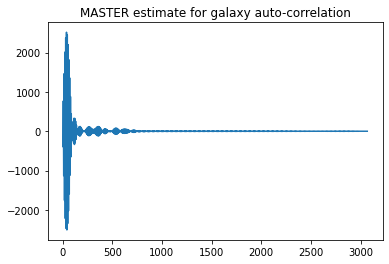

In [161]:
plt.plot(ell_arr, cl_gg[0])
plt.title("MASTER estimate for galaxy auto-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MASTER estimate for galaxy-lensing cross-correlation')

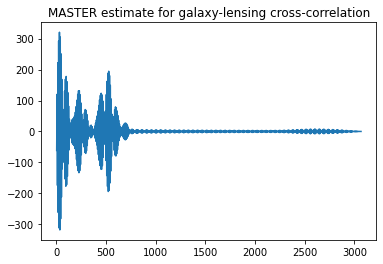

In [164]:
plt.plot(ell_arr, cl_gk[0])
plt.title("MASTER estimate for galaxy-lensing cross-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MASTER estimate for lensing auto-correlation')

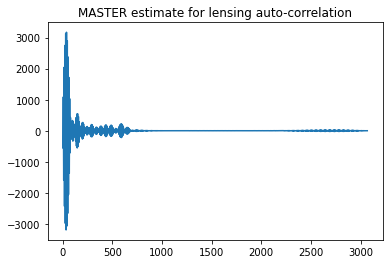

In [189]:
plt.plot(ell_arr, cl_kk[0])
plt.title("MASTER estimate for lensing auto-correlation")

In [94]:
c_ell_path = "../data/flaskv3/input/dss-0.85/dss-0.85-Cl-"

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [166]:
cl_gg_trough = pd.read_csv(c_ell_path+"f1z1f1z1.dat", sep=' ', header=None)
cl_gg_trough.columns = ['L', 'CL']
cl_gg_trough.index = np.arange(10000)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [167]:
cl_gg_trough['CL'] = cl_gg_trough['CL']*bias**2 + 1/density_steradians

In [168]:
cl_gg_trough

,L,CL
0,0.0,0.000002
1,1.0,0.000002
2,2.0,0.000021
3,3.0,0.000035
4,4.0,0.000045
...,...,...
9995,9995.0,0.000002
9996,9996.0,0.000002
9997,9997.0,0.000002
9998,9998.0,0.000002


In [169]:
cl_gk_trough = pd.read_csv(c_ell_path+"f1z1f2z1.dat", sep=' ', header=None)
cl_gk_trough.columns = ['L', 'CL']
cl_gk_trough.index = np.arange(10000)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
cl_gk_trough['CL'] = bias*cl_gk_trough['CL']

In [171]:
cl_gk_trough

,L,CL
0,0.0,0.000000e+00
1,1.0,0.000000e+00
2,2.0,3.073930e-07
3,3.0,5.163153e-07
4,4.0,6.719013e-07
...,...,...
9995,9995.0,2.910872e-10
9996,9996.0,2.910246e-10
9997,9997.0,2.909620e-10
9998,9998.0,2.908994e-10


In [172]:
cl_k1k1_trough = pd.read_csv(c_ell_path+"f2z1f2z1.dat", sep=' ', header=None)
cl_k1k1_trough.columns = ['L', 'CL']
cl_k1k1_trough.index = np.arange(10000)

cl_k2k2_trough = pd.read_csv(c_ell_path+"f2z2f2z2.dat", sep=' ', header=None)
cl_k2k2_trough.columns = ['L', 'CL']
cl_k2k2_trough.index = np.arange(10000)

cl_kk_trough = pd.read_csv(c_ell_path+"f1z1f2z1.dat", sep=' ', header=None)
cl_kk_trough.columns = ['L', 'CL']
cl_kk_trough.index = np.arange(10000)
cl_kk_trough['CL'] = cl_k1k1_trough['CL'] + cl_k2k2_trough['CL']

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [173]:
cl_kk_trough

,L,CL
0,0.0,0.000000e+00
1,1.0,0.000000e+00
2,2.0,1.951003e-08
3,3.0,2.813902e-08
4,4.0,3.265473e-08
...,...,...
9995,9995.0,8.427463e-12
9996,9996.0,8.425706e-12
9997,9997.0,8.423950e-12
9998,9998.0,8.422195e-12


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Trough_lenser galaxy auto-correlation')

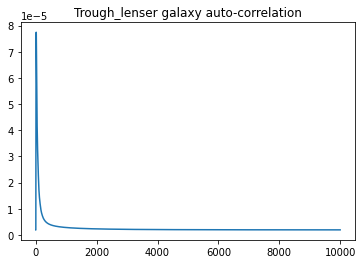

In [174]:
plt.plot(cl_gg_trough['L'], cl_gg_trough['CL'])
plt.title("Trough_lenser galaxy auto-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Trough_lenser galaxy-lensing cross-correlation')

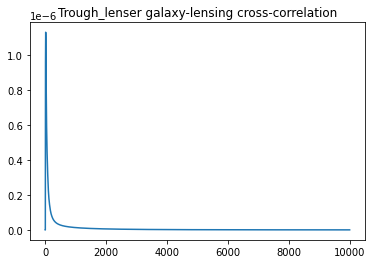

In [175]:
plt.plot(cl_gk_trough['L'], cl_gk_trough['CL'])
plt.title("Trough_lenser galaxy-lensing cross-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Trough_lenser lensing auto-correlation')

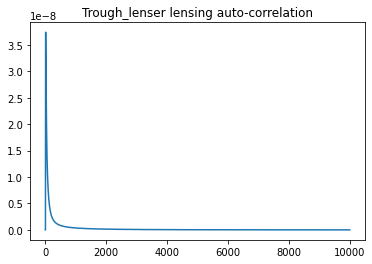

In [176]:
plt.plot(cl_kk_trough['L'], cl_kk_trough['CL'])
plt.title("Trough_lenser lensing auto-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Predicted vs. measured galaxy auto-correlations')

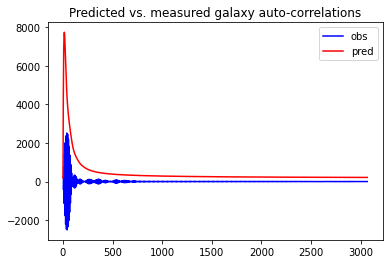

In [188]:
plt.plot(ell_arr, cl_gg[0], 'b-', label='obs')
plt.plot(cl_gg_trough['L'][:int(np.ceil(np.max(ell_arr)))], 1e8*cl_gg_trough['CL'][:int(np.ceil(np.max(ell_arr)))],
         'r-', label='pred')
plt.legend()
plt.title("Predicted vs. measured galaxy auto-correlations")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Predicted vs. measured galaxy-lensing cross-correlations')

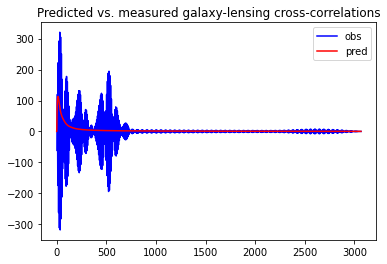

In [187]:
plt.plot(ell_arr, cl_gk[0], 'b-', label='obs')
plt.plot(cl_gk_trough['L'][:int(np.ceil(np.max(ell_arr)))], 1e8*cl_gk_trough['CL'][:int(np.ceil(np.max(ell_arr)))],
         'r-', label='pred')
plt.legend()
plt.title("Predicted vs. measured galaxy-lensing cross-correlations")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Predicted vs. measured lensing auto-correlations')

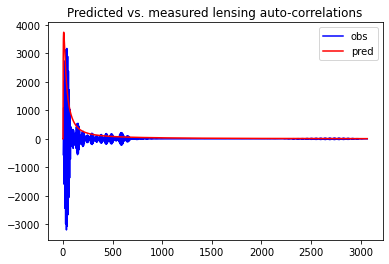

In [186]:
plt.plot(ell_arr, cl_kk[0], 'b-', label='obs')
plt.plot(cl_kk_trough['L'][:int(np.ceil(np.max(ell_arr)))], 1e11*cl_kk_trough['CL'][:int(np.ceil(np.max(ell_arr)))],
         'r-', label='pred')
plt.legend()
plt.title("Predicted vs. measured lensing auto-correlations")

In [194]:
cl_kk.shape

(1, 383)

In [196]:
hp.pixwin(1024).shape

(3072,)

In [197]:
ell_arr

array([   5.5,   13.5,   21.5,   29.5,   37.5,   45.5,   53.5,   61.5,
         69.5,   77.5,   85.5,   93.5,  101.5,  109.5,  117.5,  125.5,
        133.5,  141.5,  149.5,  157.5,  165.5,  173.5,  181.5,  189.5,
        197.5,  205.5,  213.5,  221.5,  229.5,  237.5,  245.5,  253.5,
        261.5,  269.5,  277.5,  285.5,  293.5,  301.5,  309.5,  317.5,
        325.5,  333.5,  341.5,  349.5,  357.5,  365.5,  373.5,  381.5,
        389.5,  397.5,  405.5,  413.5,  421.5,  429.5,  437.5,  445.5,
        453.5,  461.5,  469.5,  477.5,  485.5,  493.5,  501.5,  509.5,
        517.5,  525.5,  533.5,  541.5,  549.5,  557.5,  565.5,  573.5,
        581.5,  589.5,  597.5,  605.5,  613.5,  621.5,  629.5,  637.5,
        645.5,  653.5,  661.5,  669.5,  677.5,  685.5,  693.5,  701.5,
        709.5,  717.5,  725.5,  733.5,  741.5,  749.5,  757.5,  765.5,
        773.5,  781.5,  789.5,  797.5,  805.5,  813.5,  821.5,  829.5,
        837.5,  845.5,  853.5,  861.5,  869.5,  877.5,  885.5,  893.5,
      

In [203]:
rounded_ell_arr = np.floor(ell_arr).astype(int)

In [200]:
pixwin_func = hp.pixwin(1024)

In [204]:
pixwin_func[rounded_ell_arr]

array([0.99999905, 0.99999127, 0.99997917, 0.99996115, 0.99993737,
       0.99990789, 0.99987272, 0.99983185, 0.99978529, 0.99973304,
       0.9996751 , 0.99961148, 0.99954218, 0.99946719, 0.99938652,
       0.99930017, 0.99920814, 0.99911043, 0.99900705, 0.99889799,
       0.99878326, 0.99866286, 0.99853678, 0.99840504, 0.99826763,
       0.99812456, 0.99797582, 0.99782143, 0.99766137, 0.99749567,
       0.9973243 , 0.99714729, 0.99696463, 0.99677632, 0.99658237,
       0.99638278, 0.99617755, 0.99596669, 0.99575019, 0.99552807,
       0.99530032, 0.99506695, 0.99482795, 0.99458335, 0.99433313,
       0.9940773 , 0.99381587, 0.99354884, 0.99327621, 0.99299798,
       0.99271417, 0.99242477, 0.99212979, 0.99182923, 0.9915231 ,
       0.9912114 , 0.99089414, 0.99057131, 0.99024293, 0.989909  ,
       0.98956952, 0.98922451, 0.98887395, 0.98851787, 0.98815625,
       0.98778912, 0.98741647, 0.98703831, 0.98665465, 0.98626548,
       0.98587082, 0.98547067, 0.98506504, 0.98465393, 0.98423

In [205]:
cl_kk_scaled = np.multiply(cl_kk, pixwin_func)

ValueError: operands could not be broadcast together with shapes (1,383) (3072,) 